In [2]:
import pandas as pd
import math
from os import path
import matplotlib
import csv
import numpy as np
import scipy
from time import time
from collections import Counter
from scipy import stats
from pandas import DataFrame
from scipy.stats import uniform
from scipy.stats import randint
import matplotlib.pyplot as plt


In [3]:
def loadFile (disease, chrom_num):
    ## construct your file name based on the disease and chrom_number
    fileName = "D:/Shuen's Documents/School Work/MIT/BeaverWorks/Medlytics/Class stuff/Week Three/BWSI_test-20190725T191307Z-001/BWSI_test/" + str(disease) + "/Affx_gt_" + str(disease) + "_Chiamo_" + str(chrom_num) + ".tped.gz"
    dat = pd.read_csv(fileName, compression='gzip', header=None, sep='\t')
    return (dat)

In [4]:
def loadFile1 (disease, chrom_num):
    ## construct your file name based on the disease and chrom_number
    fileName = "D:/Shuen's Documents/School Work/MIT/BeaverWorks/Medlytics/Class stuff/Week Three/BWSI_test-20190725T191307Z-001/BWSI_test/" + str(disease) + "/Affx_gt_" + str(disease) + "_Chiamo_" + str(chrom_num) + ".csv"
    dat = pd.read_csv(fileName)
    return (dat)

In [5]:
## compute Allele Frequency for the minor allele
def computeAlleleFrequency (f_C, f_T):
    """
    f_C = minor allele count
    f_T = major allele count
    minor_allele_frequency = f_C/ (f_C+f_T) 
    """
    minor_allele_frequency = f_C/(f_C+f_T)
    return (minor_allele_frequency)

In [6]:
def getAlleleCounts (genotype, nucleotide):
    """
    genotype = "C C 	C T 	C T 	C T 	T T"
    Allele frequency:
    count the "Cs", and the "Ts"
    f_C = # of Cs
    f_T = # of T's
    """
    count = Counter(genotype)
    return count[nucleotide]

In [7]:
## Function takes as input the minor allele frequency (p) and the population genotype counts
## returns the p-value from the chisq test
def HWEChiSq (p, populationGenotypeCounts):
    """
        |  CC | CT  | TT |
    BP  | 270 | 957 | 771|
    compute the HWE
      -- p = frequency of the C allele
      -- q = 1-p = frequency of the T allele
      -- if the population genotype is in Hardy Weinberg Equilibrium, we would expect the genotype frequencies to be
          CC = p^2*N 
          CT = 2pq*N 
          TT = q^2*N 
      -- to compute the deviation from HWE
         (observed - expected)^2 / expected
      -- do a chi.squared test to check if the deviation is significant
    """
    q = 1-p
    total = populationGenotypeCounts.sum()
    expected_CC = (p**2)*total
    expected_CT = (2*p*q)*total
    expected_TT = (q**2)*total
    observed = populationGenotypeCounts
    expected = np.array([expected_CC, expected_CT, expected_TT])
    chi_square = sum((observed-expected)**2/(expected))
#     test_result = scipy.stats.chisquare(f_obs=observed, f_exp=expected, ddof=1, axis=0)
#     p_value = test_result[1]
    p_value = scipy.stats.chi2.sf(chi_square, 1)
    return p_value

In [8]:
## Compute the Odds Ratio
## takes as input a 2X2  confusion matrix
## returns the odds ratio
def computeOR (confusionMatrix):
    M = confusionMatrix
    Odds_Ratio = (M[0, 0]*M[1, 1])/(M[0, 1]*M[1, 0])
    return Odds_Ratio

In [9]:
## Execute a chisq test to determine if the odds ratio is significant
## return the p-value from the chisq test
def getPValue (confusionMatrix):
    M = confusionMatrix
    test_result = scipy.stats.chi2_contingency(M)
    return test_result[1]

In [10]:
## Write code to run the GWAS

## Write a function that will take the following inputs:
## (a) control files - 58C and NBS
## (b) the disease - T2D, T1D, HT, BD, CD, RA
## (c) the chromosome number

## Your function should output a csv file with the following information
## SNP Id, RSID, CHROMOSOME NUMBER, MINOR ALLELE, MAJOR ALLELE, MINOR ALLELE FREQUENCY, MAJOR ALLELE FREQUENCY, 
## ODDS RATIO (MINOR vs MAJOR ALLELE), P-Value for ODDS RATIO, Chi square for the ODDS RATIO, HWE deviation P-VALUE
## 

def gwas (controlFile, disease, chrom_num):
    """
    1. Load the control file for the specified chromosome number. Since there are two control populations, 
       it would be best to combine the two controls together
    2. Load the disease file for the given chromosome number
    3. Split the header from the SNP data for the controls and the disease
    3. Load the SNP file -- this gives you the mapping between the WTCCC SNP ids and the RSID
    4. For each SNP in the disease file and its matching SNP in the control file:
       -- to make it easier, before you begin do a check for zygosity. If either the controls or the disease 
       are homozygous, skip the SNP
       genotype CC, TT : skip
       genotype CC CT TT : run the following analysis
       a. get the minor and major allele counts and compute the minor allele frequency for the disease population
       b. get the minor and major allele counts and compute the minor allele frequency for the control population
       c. conduct the allelic test -- compute the odds ratios to test the frequency of the minor allele 
          in the disease population compared to the control population
          -- you can build a confusion matrix based on the counts that you have calculated in a and b
          -- compute your odds ratios based on the minor allele of the control population
          
          |                  | C    | T    | 
          |------------------+ ---  + ---  +
          | Bipolar Disorder | 1529 | 2469 |
          |------------------+----  + ---  +
          | Healthy Controls | 2270 | 3738 |
          |------------------+----- +----- +
          
          (Test : your OR for above should be :1.019)
       d. Do a chi square test to test the significant and record the p-value
       d. for each SNP calculate the deviation from Hardy-Weinberg equilibrium
       e. create an output row containing:
       SNP Id, RSID, CHROMOSOME NUMBER, MINOR ALLELE, MAJOR ALLELE, MINOR ALLELE FREQUENCY, 
       MAJOR ALLELE FREQUENCY, ODDS RATIO (MINOR vs MAJOR ALLELE), 
       P-Value for ODDS RATIO, CHI_SQ for the ODDS RATIO, HWE deviation P-VALUE  
    5. Save the result file for the chromosome
    """
    #loading the control and disease files
    control = loadFile(controlFile, chrom_num)
    disease = loadFile(disease, chrom_num)
    
    #splitting the control and disease into headers and bodies
    control_h = control.iloc[:, :4]
    control_b = control.iloc[:, 4:]
    disease_h = disease.iloc[:, :4]
    disease_b = disease.iloc[:, 4:]
    
    #loading the snp file
    snp_file = "D:/Shuen's Documents/School Work/MIT/BeaverWorks/Medlytics/Class stuff/Week Three/BWSI_test-20190725T191307Z-001/BWSI_test/58C/snps/snps_"+str(chrom_num)
    snp = pd.read_csv(snp_file, header=None, sep='\t')
    
    #matching the snps to the rsID's for control
    control_snps = control_h.iloc[:, 1]
    rs_list = []
    for code1 in control_snps:
        counter=0
        for code2 in snp.loc[:, 3]:
            if code1 == code2:
                rs_list.append(snp.loc[counter, 4])
                counter=0
            else:
                counter += 1
        
    control_h = control_h.assign(rs_ID = rs_list)
    control_h = control_h.rename(columns={0: 'Chromosome', 1:'SNP_ID'})
    control_h = control_h.drop([2, 3], axis=1)
    
    #matching the snps to the rsID's for disease
    disease_snps = disease_h.iloc[:, 1]
    rs_list = []
    for code1 in disease_snps:
        counter=0
        for code2 in snp.loc[:, 3]:
            if code1 == code2:
                rs_list.append(snp.loc[counter, 4])
                counter=0
            else:
                counter += 1
    disease_h = disease_h.assign(rs_ID = rs_list)
    disease_h = disease_h.rename(columns={0: 'Chromosome', 1:'SNP_ID'})
    disease_h = disease_h.drop([2, 3], axis=1)
    
    #Analysis stuff
    #Dropping homozygous rows
    for row in control.index:
        ndat = control_b.loc[row, :]
        control_string = ''
        for item in ndat:
            control_string += item
        count = Counter(control_string)
        A_count = count['A']
        G_count = count['G']
        C_count = count['C']
        T_count = count['T']
        for item in [A_count, G_count, C_count, T_count]:
            total_n = A_count+G_count+C_count+T_count
            if item/total_n == 1:
                control_h = control_h.drop(row, axis=0)
                control_b = control_b.drop(row, axis=0)
                control = control.drop(row, axis=0)
                disease_h = disease_h.drop(row, axis=0)
                disease_b = disease_b.drop(row, axis=0)
                disease = disease.drop(row, axis=0)
    for row in disease.index:
        ndat = disease_b.loc[row, :]
        disease_string = ''
        for item in ndat:
            disease_string += item
        count = Counter(disease_string)
        A_count = count['A']
        G_count = count['G']
        C_count = count['C']
        T_count = count['T']
        for item in [A_count, G_count, C_count, T_count]:
            total_n = A_count+G_count+C_count+T_count
            if item/total_n == 1:
                control_h = control_h.drop(row, axis=0)
                control_b = control_b.drop(row, axis=0)
                control = control.drop(row, axis=0)
                disease_h = disease_h.drop(row, axis=0)
                disease_b = disease_b.drop(row, axis=0)
                disease = disease.drop(row, axis=0)
    
    #getting minor and major alleles for controls
    #getting frequencies of minor and major alleles
    minor_lst_ctrl = []
    major_lst_ctrl = []
    minor_freq_lst_ctrl = []
    major_freq_lst_ctrl = []
    minor_ct_lst_ctrl = []
    major_ct_lst_ctrl = []
    for row in control.index:
        ndat = control_b.loc[row, :]
        control_string = ''
        for item in ndat:
            control_string += item
        count = Counter(control_string)
        A_count = count['A']
        G_count = count['G']
        C_count = count['C']
        T_count = count['T']
        count_list = [A_count, G_count, C_count, T_count]
        count_list.remove(0)
        count_list.remove(0)
        #this is the part appending counts
        minor_ct_lst_ctrl.append(min(count_list))
        major_ct_lst_ctrl.append(max(count_list))
        #this is the allele frequency part
        minor_freq = computeAlleleFrequency(min(count_list), max(count_list))
        minor_freq_lst_ctrl.append(minor_freq)
        major_freq_lst_ctrl.append(1-minor_freq)
        #this is the appending nucleotide part
        if max(count_list) == A_count:
            major_lst_ctrl.append('A')
        elif max(count_list) == G_count:
            major_lst_ctrl.append('G')
        elif max(count_list) == C_count:
            major_lst_ctrl.append('C')
        elif max(count_list) == T_count:
            major_lst_ctrl.append('T')
        if min(count_list) == A_count:
            minor_lst_ctrl.append('A')
        elif min(count_list) == G_count:
            minor_lst_ctrl.append('G')
        elif min(count_list) == C_count:
            minor_lst_ctrl.append('C')
        elif min(count_list) == T_count:
            minor_lst_ctrl.append('T')
    
    #getting minor and major alleles for disease
    #getting frequencies
    minor_lst_dis = []
    major_lst_dis = []
    minor_freq_lst_dis = []
    major_freq_lst_dis = []
    minor_ct_lst_dis = []
    major_ct_lst_dis = []
    for row in disease.index:
        ndat = disease_b.loc[row, :]
        disease_string = ''
        for item in ndat:
            disease_string += item
        count = Counter(disease_string)
        A_count = count['A']
        G_count = count['G']
        C_count = count['C']
        T_count = count['T']
        count_list = [A_count, G_count, C_count, T_count]
        count_list.remove(0)
        count_list.remove(0)
        #this is the count part
        minor_ct_lst_dis.append(min(count_list))
        major_ct_lst_dis.append(max(count_list))
        #this is the allele frequency part
        minor_freq = computeAlleleFrequency(min(count_list), max(count_list))
        minor_freq_lst_dis.append(minor_freq)
        major_freq_lst_dis.append(1-minor_freq)
        #this is the nucleotide appending part
        if max(count_list) == A_count:
            major_lst_dis.append('A')
        elif max(count_list) == G_count:
            major_lst_dis.append('G')
        elif max(count_list) == C_count:
            major_lst_dis.append('C')
        elif max(count_list) == T_count:
            major_lst_dis.append('T')
        if min(count_list) == A_count:
            minor_lst_dis.append('A')
        elif min(count_list) == G_count:
            minor_lst_dis.append('G')
        elif min(count_list) == C_count:
            minor_lst_dis.append('C')
        elif min(count_list) == T_count:
            minor_lst_dis.append('T')
    #odds ratio stuff
    #chi square stuff
    odds_ratio_lst = []
    chi_square_p_value_lst = []
    chi_square_odds_lst = []
    for index in range(len(minor_ct_lst_dis)):
        #odds stuff
        odds_array = np.array([[minor_ct_lst_dis[index], major_ct_lst_dis[index]],
                               [minor_ct_lst_ctrl[index], major_ct_lst_ctrl[index]]])
        odds_ratio = computeOR(odds_array)
        odds_ratio_lst.append(odds_ratio)
        #chi stuff
        chi_results_p_value = scipy.stats.chi2_contingency(odds_array)
        chi_square_p_value_lst.append(chi_results_p_value[1])
        chi_square_odds_lst.append(chi_results_p_value[0])
    
    #HW equilibrium stuff on the control population
    pop_Gen_lst_ctrl = []
    HWE_deviation_lst = []
    index_1 = 0
    for row in control.index:
        ndat = control_b.loc[row, :]
        minor = minor_lst_ctrl[index_1]
        major = major_lst_ctrl[index_1]
        CC_num = 0
        CT_num = 0
        TT_num = 0
        for data in ndat:
            if data.count(minor) == 2:
                CC_num +=1
            elif data.count(minor) == 1:
                CT_num +=1
            elif data.count(major) == 2:
                TT_num +=1
        observed = np.array([CC_num, CT_num, TT_num])
        pop_Gen_lst_ctrl.append(observed)
        index_1 += 1
        
    for index in range(len(minor_ct_lst_ctrl)):
        p = minor_freq_lst_ctrl[index]
        populationGenotypeCounts = pop_Gen_lst_ctrl[index]
        HWE = HWEChiSq(p, populationGenotypeCounts)
        HWE_deviation_lst.append(HWE)
    
#     make a dataframe and save it
    df = pd.concat([control_h], axis=1)
    df.loc[:, 'Minor Allele'] = minor_lst_ctrl
    df.loc[:, 'Major Allele'] = major_lst_ctrl
    df.loc[:, 'Minor Allele Frequency for Control'] = minor_freq_lst_ctrl
    df.loc[:, 'Major Allele Frequency for Control'] = major_freq_lst_ctrl
    df.loc[:, 'Minor Allele Frequency for Disease'] = minor_freq_lst_dis
    df.loc[:, 'Major Allele Frequency for Disease'] = major_freq_lst_dis
    df.loc[:, 'Odds Ratio'] = odds_ratio_lst
    df.loc[:, 'P-Value for Odds Ratio'] = chi_square_p_value_lst
    df.loc[:, 'Chi Square Value for Odds Ratio'] = chi_square_odds_lst
    df.loc[:, 'P-Value for Hardy-Weinberg Deviation'] = HWE_deviation_lst
    return df

In [11]:
for number in ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22']:
    file = gwas('58C', 'RA', number)
    file.to_csv(path_or_buf="D:/Shuen's Documents/School Work/MIT/BeaverWorks/Medlytics/Class stuff/Week Three/RA 58C 1000 data/RA1kdata_num" + str(number) + ".csv")

In [11]:
def runGWAS (disease):
    """
    1. For each chromosome 1:22 call the gwas function
    2. Merge all the result files into one 
    3. Filter your data
       a. remove all SNPs that deviate signficantly from HWE equilibrium -- these may indicate an error or 
          population specific deviation. For this remove all SNPs for which HWE deviation P-Value < 0.05
       b. remove all SNPs that have minor allele frequency less than 1% -- not enough data
    4. Draw a manhattan plot
       c. draw a line at your Bonferroni threshold (Bonferroni correction): 
       if your significance is set at p.value < 0.05, then Bonferroni correction = 0.05/number of tests that you ran
    """
    big_file = gwas('58C', disease, '01')
    for number in ['02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22']:
        file = gwas('58C', disease, number)
        big_file = pd.concat([big_file, file], axis=0, ignore_index=True)
    
    for row in big_file.index:
        dat = big_file.loc[row, :]
        if dat.iloc[12] < 0.05 or dat.iloc[5] < 0.01 or dat.iloc[7] < 0.01:
             big_file = big_file.drop(row, axis=0)
    big_file = big_file.reset_index(drop=True)
    return big_file

In [12]:
h = gwas('58C', 'RA', '01')
h.head()

,Chromosome,SNP_ID,rs_ID,Minor Allele,Major Allele,Minor Allele Frequency for Control,Major Allele Frequency for Control,Minor Allele Frequency for Disease,Major Allele Frequency for Disease,Odds Ratio,P-Value for Odds Ratio,Chi Square Value for Odds Ratio,P-Value for Hardy-Weinberg Deviation
0,1,SNP_A-1938722,rs761296,T,C,0.469082,0.530918,0.452226,0.547774,0.934399,0.168467,1.896531,0.922660
1,1,SNP_A-4217222,rs11582843,C,T,0.349069,0.650931,0.358679,0.641321,1.042928,0.419618,0.651386,0.148283
2,1,SNP_A-2023862,rs3009323,A,T,0.002327,0.997673,0.001501,0.998499,0.644360,0.606460,0.265363,0.927922
3,1,SNP_A-4196224,rs17114028,A,G,0.092088,0.907912,0.093547,0.906453,1.017479,0.867651,0.027770,0.142584
4,1,SNP_A-2286934,rs16832860,G,A,0.455785,0.544215,0.453977,0.546023,0.992737,0.899604,0.015917,0.277778


In [12]:
def BigFile (disease):
    big_file = gwas('58C', disease, '01')
    for number in ['02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22']:
        file = gwas('58C', disease, number)
        big_file = pd.concat([big_file, file], axis=0, ignore_index=True)
    return big_file

In [14]:
big_file = runGWAS('RA')
big_file.to_csv(path_or_buf="D:/Shuen's Documents/School Work/MIT/BeaverWorks/Medlytics/Class stuff/Week Three/RA 58C 1000 data/AllData1k.csv")

In [14]:
AllData1k = pd.read_csv("D:/Shuen's Documents/School Work/MIT/BeaverWorks/Medlytics/Class stuff/Week Three/RA 58C 1000 data/AllData1k.csv")

In [137]:
# AllData1k.head()

In [25]:
len(BigFile('RA'))

21035

In [15]:
def plotRA (disease):
    """
    1. For each chromosome 1:22 call the gwas function
    2. Merge all the result files into one 
    3. Filter your data
       a. remove all SNPs that deviate signficantly from HWE equilibrium -- these may indicate an error or 
          population specific deviation. For this remove all SNPs for which HWE deviation P-Value < 0.05
       b. remove all SNPs that have minor allele frequency less than 1% -- not enough data
    4. Draw a manhattan plot
       c. draw a line at your Bonferroni threshold (Bonferroni correction): 
       if your significance is set at p.value < 0.05, then Bonferroni correction = 0.05/number of tests that you ran
    """
    x_list = []
    y_list = []
    for chrom_num in AllData1k.iloc[:, 1]:
        x_list.append(chrom_num)
    for value in AllData1k.iloc[:, 11]:
        if value != 0:
            y_list.append(-1*math.log10(value))
        else:
            y_list.append(30)
    plt.plot(x_list, y_list, 'bo')
    plt.hlines(-1*math.log10(0.05/21035), -1, 23, 'r',{'dashed'})

In [16]:
count = 0
df_ = AllData1k.iloc[:, [1, 2, 6, 8, 9, 11, 13]]
for row in df_.index:
    if df_.iloc[row, 5] < 0.05/21035:
        print(df_.iloc[row, :])
        count +=1
print('hi my name is ' + str(count))

Chromosome                                          2
SNP_ID                                  SNP_A-1967003
Minor Allele Frequency for Control          0.0388963
Minor Allele Frequency for Disease          0.0125063
Major Allele Frequency for Disease           0.987494
P-Value for Odds Ratio                    1.35478e-12
P-Value for Hardy-Weinberg Deviation         0.116531
Name: 1292, dtype: object
Chromosome                                          3
SNP_ID                                  SNP_A-2093721
Minor Allele Frequency for Control           0.463763
Minor Allele Frequency for Disease          0.0655328
Major Allele Frequency for Disease           0.934467
P-Value for Odds Ratio                              0
P-Value for Hardy-Weinberg Deviation         0.498681
Name: 1862, dtype: object
Chromosome                                          4
SNP_ID                                  SNP_A-2257315
Minor Allele Frequency for Control          0.0378989
Minor Allele Frequency for Dis

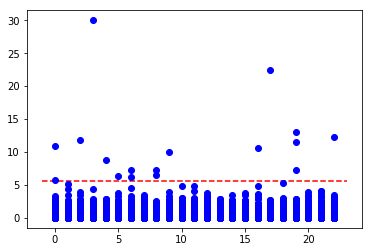

In [17]:
plotRA('RA')

## Merging controls and getting final dataset

In [80]:
index_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22']
for index in index_list:
    C58file = loadFile('58C', index)
    nbs_file = loadFile('NBS', index)
    a = pd.concat([C58file, nbs_file], axis=1, ignore_index=True)
    a.drop([1508, 1509, 1510, 1511], axis=1, inplace=True)
    a = a.T.reset_index(drop=True).T
    filepath = "D:/Shuen's Documents/School Work/MIT/BeaverWorks/Medlytics/Class stuff/Week Three/BWSI_test-20190725T191307Z-001/BWSI_test/CTRL/Affx_gt_CTRL_Chiamo_" + str(index) + ".csv"
    a.to_csv(path_or_buf=filepath, index=False)

In [272]:
# # counter_poo = 0
# haha = loadFile('58C', '01')
# # for item in haha.iloc[:, 0]:
# #     if item == 0:
# #         print(counter_poo)
# #         counter_poo += 1
# #     else:
# #         counter_poo += 1

In [271]:
# #91 SNP_A-2239604
# haha.iloc[0:100, 0:1]

In [13]:
def gwas2 (controlFile, disease, chrom_num):
    """
    1. Load the control file for the specified chromosome number. Since there are two control populations, 
       it would be best to combine the two controls together
    2. Load the disease file for the given chromosome number
    3. Split the header from the SNP data for the controls and the disease
    3. Load the SNP file -- this gives you the mapping between the WTCCC SNP ids and the RSID
    4. For each SNP in the disease file and its matching SNP in the control file:
       -- to make it easier, before you begin do a check for zygosity. If either the controls or the disease 
       are homozygous, skip the SNP
       genotype CC, TT : skip
       genotype CC CT TT : run the following analysis
       a. get the minor and major allele counts and compute the minor allele frequency for the disease population
       b. get the minor and major allele counts and compute the minor allele frequency for the control population
       c. conduct the allelic test -- compute the odds ratios to test the frequency of the minor allele 
          in the disease population compared to the control population
          -- you can build a confusion matrix based on the counts that you have calculated in a and b
          -- compute your odds ratios based on the minor allele of the control population
          
          |                  | C    | T    | 
          |------------------+ ---  + ---  +
          | Bipolar Disorder | 1529 | 2469 |
          |------------------+----  + ---  +
          | Healthy Controls | 2270 | 3738 |
          |------------------+----- +----- +
          
          (Test : your OR for above should be :1.019)
       d. Do a chi square test to test the significant and record the p-value
       d. for each SNP calculate the deviation from Hardy-Weinberg equilibrium
       e. create an output row containing:
       SNP Id, RSID, CHROMOSOME NUMBER, MINOR ALLELE, MAJOR ALLELE, MINOR ALLELE FREQUENCY, 
       MAJOR ALLELE FREQUENCY, ODDS RATIO (MINOR vs MAJOR ALLELE), 
       P-Value for ODDS RATIO, CHI_SQ for the ODDS RATIO, HWE deviation P-VALUE  
    5. Save the result file for the chromosome
    """
    #loading the control and disease files
    control = loadFile1(controlFile, chrom_num)
    disease = loadFile(disease, chrom_num)
    
    for row in control.index:
        if control.loc[row, '0'] == 0:
            control = control.drop(row, axis=0)
            disease = disease.drop(row, axis=0)

    #splitting the control and disease into headers and bodies
    control_h = control.iloc[:, :4]
    control_b = control.iloc[:, 4:]
    disease_h = disease.iloc[:, :4]
    disease_b = disease.iloc[:, 4:]
    
    #loading the snp file
    snp_file = "D:/Shuen's Documents/School Work/MIT/BeaverWorks/Medlytics/Class stuff/Week Three/BWSI_test-20190725T191307Z-001/BWSI_test/58C/snps/snps_"+str(chrom_num)
    snp = pd.read_csv(snp_file, header=None, sep='\t')
    
    #matching the snps to the rsID's for control
    control_snps = control_h.iloc[:, 1]
    rs_list = []
    for code1 in control_snps:
        counter=0
        for code2 in snp.loc[:, 3]:
            if code1 == code2:
                rs_list.append(snp.loc[counter, 4])
                counter=0
            else:
                counter += 1
        
    control_h = control_h.assign(rs_ID = rs_list)
    control_h = control_h.rename(columns={'0': 'Chromosome', '1':'SNP_ID'})
    control_h = control_h.drop(['2', '3'], axis=1)
    
    #matching the snps to the rsID's for disease
    disease_snps = disease_h.iloc[:, 1]
    rs_list = []
    for code1 in disease_snps:
        counter=0
        for code2 in snp.loc[:, 3]:
            if code1 == code2:
                rs_list.append(snp.loc[counter, 4])
                counter=0
            else:
                counter += 1
    disease_h = disease_h.assign(rs_ID = rs_list)
    disease_h = disease_h.rename(columns={0: 'Chromosome', 1:'SNP_ID'})
    disease_h = disease_h.drop([2, 3], axis=1)
    
    #Analysis stuff
    #Dropping homozygous rows
    for row in control.index:
        ndat = control_b.loc[row, :]
        control_string = ''
        for item in ndat:
            control_string += item
        count = Counter(control_string)
        A_count = count['A']
        G_count = count['G']
        C_count = count['C']
        T_count = count['T']
        for item in [A_count, G_count, C_count, T_count]:
            total_n = A_count+G_count+C_count+T_count
            if item/total_n == 1:
                control_h = control_h.drop(row, axis=0)
                control_b = control_b.drop(row, axis=0)
                control = control.drop(row, axis=0)
                disease_h = disease_h.drop(row, axis=0)
                disease_b = disease_b.drop(row, axis=0)
                disease = disease.drop(row, axis=0)
    for row in disease.index:
        ndat = disease_b.loc[row, :]
        disease_string = ''
        for item in ndat:
            disease_string += item
        count = Counter(disease_string)
        A_count = count['A']
        G_count = count['G']
        C_count = count['C']
        T_count = count['T']
        for item in [A_count, G_count, C_count, T_count]:
            total_n = A_count+G_count+C_count+T_count
            if item/total_n == 1:
                control_h = control_h.drop(row, axis=0)
                control_b = control_b.drop(row, axis=0)
                control = control.drop(row, axis=0)
                disease_h = disease_h.drop(row, axis=0)
                disease_b = disease_b.drop(row, axis=0)
                disease = disease.drop(row, axis=0)
    
    #getting minor and major alleles for controls
    #getting frequencies of minor and major alleles
    minor_lst_ctrl = []
    major_lst_ctrl = []
    minor_freq_lst_ctrl = []
    major_freq_lst_ctrl = []
    minor_ct_lst_ctrl = []
    major_ct_lst_ctrl = []
    for row in control.index:
        ndat = control_b.loc[row, :]
        control_string = ''
        for item in ndat:
            control_string += item
        count = Counter(control_string)
        A_count = count['A']
        G_count = count['G']
        C_count = count['C']
        T_count = count['T']
        count_list = [A_count, G_count, C_count, T_count]
        count_list.remove(0)
        count_list.remove(0)
        #this is the part appending counts
        minor_ct_lst_ctrl.append(min(count_list))
        major_ct_lst_ctrl.append(max(count_list))
        #this is the allele frequency part
        minor_freq = computeAlleleFrequency(min(count_list), max(count_list))
        minor_freq_lst_ctrl.append(minor_freq)
        major_freq_lst_ctrl.append(1-minor_freq)
        #this is the appending nucleotide part
        if max(count_list) == A_count:
            major_lst_ctrl.append('A')
        elif max(count_list) == G_count:
            major_lst_ctrl.append('G')
        elif max(count_list) == C_count:
            major_lst_ctrl.append('C')
        elif max(count_list) == T_count:
            major_lst_ctrl.append('T')
        if min(count_list) == A_count:
            minor_lst_ctrl.append('A')
        elif min(count_list) == G_count:
            minor_lst_ctrl.append('G')
        elif min(count_list) == C_count:
            minor_lst_ctrl.append('C')
        elif min(count_list) == T_count:
            minor_lst_ctrl.append('T')
    
    #getting minor and major alleles for disease
    #getting frequencies
    minor_lst_dis = []
    major_lst_dis = []
    minor_freq_lst_dis = []
    major_freq_lst_dis = []
    minor_ct_lst_dis = []
    major_ct_lst_dis = []
    for row in disease.index:
        ndat = disease_b.loc[row, :]
        disease_string = ''
        for item in ndat:
            disease_string += item
        count = Counter(disease_string)
        A_count = count['A']
        G_count = count['G']
        C_count = count['C']
        T_count = count['T']
        count_list = [A_count, G_count, C_count, T_count]
        count_list.remove(0)
        count_list.remove(0)
        #this is the count part
        minor_ct_lst_dis.append(min(count_list))
        major_ct_lst_dis.append(max(count_list))
        #this is the allele frequency part
        minor_freq = computeAlleleFrequency(min(count_list), max(count_list))
        minor_freq_lst_dis.append(minor_freq)
        major_freq_lst_dis.append(1-minor_freq)
        #this is the nucleotide appending part
        if max(count_list) == A_count:
            major_lst_dis.append('A')
        elif max(count_list) == G_count:
            major_lst_dis.append('G')
        elif max(count_list) == C_count:
            major_lst_dis.append('C')
        elif max(count_list) == T_count:
            major_lst_dis.append('T')
        if min(count_list) == A_count:
            minor_lst_dis.append('A')
        elif min(count_list) == G_count:
            minor_lst_dis.append('G')
        elif min(count_list) == C_count:
            minor_lst_dis.append('C')
        elif min(count_list) == T_count:
            minor_lst_dis.append('T')
    #odds ratio stuff
    #chi square stuff
    odds_ratio_lst = []
    chi_square_p_value_lst = []
    chi_square_odds_lst = []
    for index in range(len(minor_ct_lst_dis)):
        #odds stuff
        odds_array = np.array([[minor_ct_lst_dis[index], major_ct_lst_dis[index]],
                               [minor_ct_lst_ctrl[index], major_ct_lst_ctrl[index]]])
        odds_ratio = computeOR(odds_array)
        odds_ratio_lst.append(odds_ratio)
        #chi stuff
        chi_results_p_value = scipy.stats.chi2_contingency(odds_array)
        chi_square_p_value_lst.append(chi_results_p_value[1])
        chi_square_odds_lst.append(chi_results_p_value[0])
    
    #HW equilibrium stuff on the control population
    pop_Gen_lst_ctrl = []
    HWE_deviation_lst = []
    index_1 = 0
    for row in control.index:
        ndat = control_b.loc[row, :]
        minor = minor_lst_ctrl[index_1]
        major = major_lst_ctrl[index_1]
        CC_num = 0
        CT_num = 0
        TT_num = 0
        for data in ndat:
            if data.count(minor) == 2:
                CC_num +=1
            elif data.count(minor) == 1:
                CT_num +=1
            elif data.count(major) == 2:
                TT_num +=1
        observed = np.array([CC_num, CT_num, TT_num])
        pop_Gen_lst_ctrl.append(observed)
        index_1 += 1
        
    for index in range(len(minor_ct_lst_ctrl)):
        p = minor_freq_lst_ctrl[index]
        populationGenotypeCounts = pop_Gen_lst_ctrl[index]
        HWE = HWEChiSq(p, populationGenotypeCounts)
        HWE_deviation_lst.append(HWE)
    
#     make a dataframe and save it
    df = pd.concat([control_h], axis=1)
    df.loc[:, 'Minor Allele'] = minor_lst_ctrl
    df.loc[:, 'Major Allele'] = major_lst_ctrl
    df.loc[:, 'Minor Allele Frequency for Control'] = minor_freq_lst_ctrl
    df.loc[:, 'Major Allele Frequency for Control'] = major_freq_lst_ctrl
    df.loc[:, 'Minor Allele Frequency for Disease'] = minor_freq_lst_dis
    df.loc[:, 'Major Allele Frequency for Disease'] = major_freq_lst_dis
    df.loc[:, 'Odds Ratio'] = odds_ratio_lst
    df.loc[:, 'P-Value for Odds Ratio'] = chi_square_p_value_lst
    df.loc[:, 'Chi Square Value for Odds Ratio'] = chi_square_odds_lst
    df.loc[:, 'P-Value for Hardy-Weinberg Deviation'] = HWE_deviation_lst
    return df

In [237]:
# ur_mom = gwas2('CTRL', 'RA', '19')
# counter_gay = 0
# for item in ur_mom.iloc[:, 0]:
#     if item == 0:
#         print(counter_gay)
#         counter_gay += 1
#     else:
#         counter_gay += 1

In [14]:
def runGWAS2 (disease):
    """
    1. For each chromosome 1:22 call the gwas function
    2. Merge all the result files into one 
    3. Filter your data
       a. remove all SNPs that deviate signficantly from HWE equilibrium -- these may indicate an error or 
          population specific deviation. For this remove all SNPs for which HWE deviation P-Value < 0.05
       b. remove all SNPs that have minor allele frequency less than 1% -- not enough data
    """
       
    big_file = gwas2('CTRL', disease, '01')
    for number in ['02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22']:
        file = gwas2('CTRL', disease, number)
        big_file = pd.concat([big_file, file], axis=0, ignore_index=True)
        
    for row in big_file.index:
        dat = big_file.loc[row, :]
        if dat.iloc[12] < 0.05 or dat.iloc[5] < 0.01 or dat.iloc[7] < 0.01:
             big_file = big_file.drop(row, axis=0)
    big_file = big_file.reset_index(drop=True)
    return big_file

In [240]:
#before data cleaning, 21239 rows
#after cleaning, 16837
runGWAS2('RA')

,Chromosome,SNP_ID,rs_ID,Minor Allele,Major Allele,Minor Allele Frequency for Control,Major Allele Frequency for Control,Minor Allele Frequency for Disease,Major Allele Frequency for Disease,Odds Ratio,P-Value for Odds Ratio,Chi Square Value for Odds Ratio,P-Value for Hardy-Weinberg Deviation
0,1,SNP_A-1938722,rs761296,T,C,0.460220,0.539780,0.452226,0.547774,0.968292,0.443841,0.586333,0.594201
1,1,SNP_A-4217222,rs11582843,C,T,0.347703,0.652297,0.358679,0.641321,1.049223,0.269331,1.220152,0.429353
2,1,SNP_A-4196224,rs17114028,A,G,0.091877,0.908123,0.093547,0.906453,1.020044,0.804900,0.061014,0.462737
3,1,SNP_A-2286934,rs16832860,G,A,0.466711,0.533289,0.453977,0.546023,0.950030,0.218306,1.515471,0.261141
4,1,SNP_A-2056136,rs861590,C,A,0.467210,0.532790,0.460730,0.539270,0.974281,0.537817,0.379601,0.350797
5,1,SNP_A-4241328,rs7518654,C,G,0.363182,0.636818,0.368434,0.631566,1.022896,0.607813,0.263372,0.951691
6,1,SNP_A-1872388,rs2148154,G,A,0.458722,0.541278,0.458729,0.541271,1.000031,0.984261,0.000389,0.832312
7,1,SNP_A-4278084,rs705672,C,T,0.258489,0.741511,0.256128,0.743872,0.987723,0.809432,0.058158,0.264727
8,1,SNP_A-1807549,rs11119107,A,G,0.293442,0.706558,0.309655,0.690345,1.080033,0.087030,2.928474,0.883221
9,1,SNP_A-4212440,rs6657123,A,G,0.229694,0.770306,0.213607,0.786393,0.910940,0.061735,3.490154,0.717290


In [15]:
def BigFile (disease):
    big_file = gwas2('CTRL', disease, '01')
    for number in ['02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22']:
        file = gwas2('CTRL', disease, number)
        big_file = pd.concat([big_file, file], axis=0, ignore_index=True)
    return big_file

In [244]:
big_file1 = runGWAS2('RA')
big_file1.to_csv(path_or_buf="D:/Shuen's Documents/School Work/MIT/BeaverWorks/Medlytics/Class stuff/Week Three/RA 1000 Data/AllData1000.csv", index=False)

In [246]:
BigFile('RA')

,Chromosome,SNP_ID,rs_ID,Minor Allele,Major Allele,Minor Allele Frequency for Control,Major Allele Frequency for Control,Minor Allele Frequency for Disease,Major Allele Frequency for Disease,Odds Ratio,P-Value for Odds Ratio,Chi Square Value for Odds Ratio,P-Value for Hardy-Weinberg Deviation
0,1,SNP_A-1938722,rs761296,T,C,0.460220,0.539780,0.452226,0.547774,0.968292,0.443841,0.586333,5.942010e-01
1,1,SNP_A-4217222,rs11582843,C,T,0.347703,0.652297,0.358679,0.641321,1.049223,0.269331,1.220152,4.293534e-01
2,1,SNP_A-2023862,rs3009323,A,T,0.001165,0.998835,0.001501,0.998499,1.288506,0.862477,0.030006,9.490237e-01
3,1,SNP_A-4196224,rs17114028,A,G,0.091877,0.908123,0.093547,0.906453,1.020044,0.804900,0.061014,4.627370e-01
4,1,SNP_A-2286934,rs16832860,G,A,0.466711,0.533289,0.453977,0.546023,0.950030,0.218306,1.515471,2.611405e-01
5,1,SNP_A-2126188,rs4233087,G,C,0.004328,0.995672,0.005003,0.994997,1.156747,0.735372,0.114236,2.641999e-97
6,1,SNP_A-2056136,rs861590,C,A,0.467210,0.532790,0.460730,0.539270,0.974281,0.537817,0.379601,3.507967e-01
7,1,SNP_A-4241328,rs7518654,C,G,0.363182,0.636818,0.368434,0.631566,1.022896,0.607813,0.263372,9.516905e-01
8,1,SNP_A-1872388,rs2148154,G,A,0.458722,0.541278,0.458729,0.541271,1.000031,0.984261,0.000389,8.323120e-01
9,1,SNP_A-4278084,rs705672,C,T,0.258489,0.741511,0.256128,0.743872,0.987723,0.809432,0.058158,2.647269e-01


In [16]:
AllData1000 = pd.read_csv("D:/Shuen's Documents/School Work/MIT/BeaverWorks/Medlytics/Class stuff/Week Three/RA 1000 Data/AllData1000.csv")
AllData1000

,Chromosome,SNP_ID,rs_ID,Minor Allele,Major Allele,Minor Allele Frequency for Control,Major Allele Frequency for Control,Minor Allele Frequency for Disease,Major Allele Frequency for Disease,Odds Ratio,P-Value for Odds Ratio,Chi Square Value for Odds Ratio,P-Value for Hardy-Weinberg Deviation
0,1,SNP_A-1938722,rs761296,T,C,0.460220,0.539780,0.452226,0.547774,0.968292,0.443841,0.586333,0.594201
1,1,SNP_A-4217222,rs11582843,C,T,0.347703,0.652297,0.358679,0.641321,1.049223,0.269331,1.220152,0.429353
2,1,SNP_A-4196224,rs17114028,A,G,0.091877,0.908123,0.093547,0.906453,1.020044,0.804900,0.061014,0.462737
3,1,SNP_A-2286934,rs16832860,G,A,0.466711,0.533289,0.453977,0.546023,0.950030,0.218306,1.515471,0.261141
4,1,SNP_A-2056136,rs861590,C,A,0.467210,0.532790,0.460730,0.539270,0.974281,0.537817,0.379601,0.350797
5,1,SNP_A-4241328,rs7518654,C,G,0.363182,0.636818,0.368434,0.631566,1.022896,0.607813,0.263372,0.951691
6,1,SNP_A-1872388,rs2148154,G,A,0.458722,0.541278,0.458729,0.541271,1.000031,0.984261,0.000389,0.832312
7,1,SNP_A-4278084,rs705672,C,T,0.258489,0.741511,0.256128,0.743872,0.987723,0.809432,0.058158,0.264727
8,1,SNP_A-1807549,rs11119107,A,G,0.293442,0.706558,0.309655,0.690345,1.080033,0.087030,2.928474,0.883221
9,1,SNP_A-4212440,rs6657123,A,G,0.229694,0.770306,0.213607,0.786393,0.910940,0.061735,3.490154,0.717290


In [17]:
def plotRA1 (disease):
    """
    1. For each chromosome 1:22 call the gwas function
    2. Merge all the result files into one 
    3. Filter your data
       a. remove all SNPs that deviate signficantly from HWE equilibrium -- these may indicate an error or 
          population specific deviation. For this remove all SNPs for which HWE deviation P-Value < 0.05
       b. remove all SNPs that have minor allele frequency less than 1% -- not enough data
    
    """
    x_list = []
    y_list = []
    for chrom_num in AllData1000.iloc[:, 0]:
        x_list.append(chrom_num)
    for value in AllData1000.iloc[:, 10]:
        if value != 0:
            y_list.append(-1*math.log10(value))
        else:
            y_list.append(50)
    plt.plot(x_list, y_list, 'bo')
    plt.hlines(-1*math.log10(0.05/21239), -1, 23, 'r',{'dashed'})

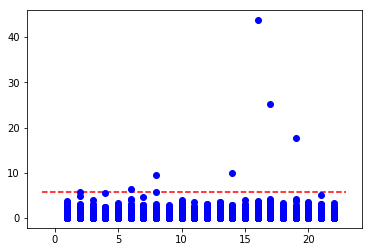

In [18]:
plotRA1('RA')

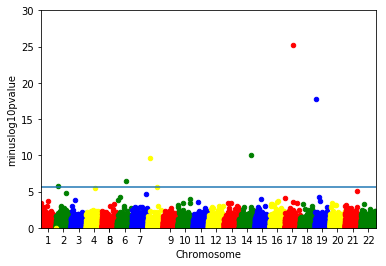

In [19]:
#Graphing time, try to get the REAL Manhattan Plot
df = DataFrame({'gene' : ['gene-%i' % i for i in np.arange(16837)], 'pvalue' : AllData1000.iloc[:, 10],'chromosome' : AllData1000.iloc[:, 0]})

# -log_10(pvalue)
df['minuslog10pvalue'] = -np.log10(df.pvalue)

# How to plot gene vs. -log10(pvalue) and colour it by chromosome?
df['ind'] = range(len(df))
df_grouped = df.groupby(('chromosome'))

fig = plt.figure()
ax = fig.add_subplot(111)
colors = ['red','green','blue', 'yellow']
x_labels = []
x_labels_pos = []
for num, (name, group) in enumerate(df_grouped):
    group.plot(kind='scatter', x='ind', y='minuslog10pvalue',color=colors[num % len(colors)], ax=ax)
    x_labels.append(name)
    x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))
ax.set_xticks(x_labels_pos)
ax.set_xticklabels(x_labels)
ax.set_xlim([0, len(df)])
ax.set_ylim([0, 30])
ax.set_xlabel('Chromosome')
plt.axhline(y=-1*math.log10(0.05/21239), xmin=0, xmax=23)

In [20]:
significant_list = []
df_1 = AllData1000.iloc[:, [0, 1, 5, 7, 8, 10, 12]]
for row in df_1.index:
    if df_1.iloc[row, 5] < 0.05/21239:
        significant_list.append(df_1.iloc[row, 1])

In [21]:
significant_list

['SNP_A-1829615',
 'SNP_A-2201779',
 'SNP_A-4200620',
 'SNP_A-4258952',
 'SNP_A-1894270',
 'SNP_A-2051764',
 'SNP_A-1955468',
 'SNP_A-1874146']

In [22]:
alleles_freq_all = pd.read_csv("D:/Shuen's Documents/School Work/MIT/BeaverWorks/Medlytics/Class stuff/Week Three/alleles_freq_all_all.csv")
alleles_freq_all.head()

,SNP,rsid,Chrs,Disease,Minor,Major,Minor_f_cases,Minor_f_ctrl,OR_major,pval,chi2,pval_HW
0,SNP_A-1780278,rs17571465,1,BD,t,a,0.077327,0.069075,1.129489,0.118678,2.434675,0.449208
1,SNP_A-1780304,rs16843226,1,BD,g,a,0.194444,0.195739,0.991790,0.872883,0.025599,0.719856
2,SNP_A-1780320,rs679735,1,BD,c,t,0.272022,0.284288,0.940733,0.180526,1.793286,0.314432
3,SNP_A-1780336,rs12047850,1,BD,c,a,0.211211,0.210719,1.002961,0.952872,0.003493,0.303212
4,SNP_A-1780384,rs6703187,1,BD,g,a,0.350100,0.334221,1.073105,0.100702,2.694388,0.482863


In [26]:
RA_alleles_freq_all = alleles_freq_all
RA_alleles_freq_all = RA_alleles_freq_all[RA_alleles_freq_all.iloc[:, 3] == 'RA']
RA_alleles_freq_all = RA_alleles_freq_all[RA_alleles_freq_all.iloc[:, 0].isin(significant_list)]
# for row in RA_alleles_freq_all.index:
#     if RA_alleles_freq_all.iloc[row, 0] not in significant_list:
#         RA_alleles_freq_all = RA_alleles_freq_all.drop(row, axis=0)

In [28]:
RA_alleles_freq_all

,SNP,rsid,Chrs,Disease,Minor,Major,Minor_f_cases,Minor_f_ctrl,OR_major,pval,chi2,pval_HW
339398,SNP_A-1829615,rs6542010,2,RA,c,t,0.357179,0.311085,1.230499,1.549801e-06,23.085187,0.817594
1075087,SNP_A-2201779,rs41431449,6,RA,a,g,0.054027,0.033123,1.667172,2.793163e-07,26.387680,0.060437
1376456,SNP_A-4200620,rs6989827,8,RA,t,c,0.566283,0.498336,1.314373,2.612337e-11,44.447775,0.511677
1378835,SNP_A-4258952,rs7832533,8,RA,t,c,0.095798,0.126664,0.730494,2.008769e-06,22.586637,0.064807
2134639,SNP_A-1894270,rs41456047,14,RA,g,a,0.584542,0.481358,1.515962,4.438301e-24,102.443578,0.067209
2294979,SNP_A-2051764,rs41449646,16,RA,a,g,0.218109,0.348702,0.521019,1.364522e-44,196.264769,0.306266
2362132,SNP_A-1955468,rs41510050,17,RA,c,t,0.058279,0.018808,3.228467,3.519737e-26,112.029834,0.293434
2484547,SNP_A-1874146,rs11671119,19,RA,t,c,0.072036,0.033289,2.254318,1.207654e-18,77.686476,0.703581


In [36]:
from math import log10

In [37]:
RA_genotype_data = loadFile('RA', '01')
for number in ['02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22']:
    data = loadFile('RA', number)
    RA_genotype_data = pd.concat([RA_genotype_data, data], axis=0, ignore_index=True)

In [38]:
RA_genotype_data.head()

,0,1,2,3,4,5,6,7,8,9,...,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002
0,1,SNP_A-1938722,0,15385344,C C,C C,C T,C C,C T,C C,...,T T,C T,C C,C C,C T,C T,C T,C T,C C,C C
1,1,SNP_A-4217222,0,243847383,C T,C T,C T,T T,T T,T T,...,C T,T T,T T,T T,T T,T T,C T,C T,T T,C T
2,1,SNP_A-2023862,0,192847341,T T,T T,T T,T T,T T,T T,...,T T,T T,T T,T T,T T,T T,T T,T T,T T,T T
3,1,SNP_A-4196224,0,95890895,G G,G G,G G,A G,G G,A G,...,G G,G G,G G,G G,G G,G G,G G,G G,G G,G G
4,1,SNP_A-2286934,0,189084167,A G,A G,A G,A G,A G,A G,...,A G,A G,A G,G G,G G,A G,A A,A G,A A,A A


In [33]:
RA_alleles_freq_all

,SNP,rsid,Chrs,Disease,Minor,Major,Minor_f_cases,Minor_f_ctrl,OR_major,pval,chi2,pval_HW
339398,SNP_A-1829615,rs6542010,2,RA,c,t,0.357179,0.311085,1.230499,1.549801e-06,23.085187,0.817594
1075087,SNP_A-2201779,rs41431449,6,RA,a,g,0.054027,0.033123,1.667172,2.793163e-07,26.387680,0.060437
1376456,SNP_A-4200620,rs6989827,8,RA,t,c,0.566283,0.498336,1.314373,2.612337e-11,44.447775,0.511677
1378835,SNP_A-4258952,rs7832533,8,RA,t,c,0.095798,0.126664,0.730494,2.008769e-06,22.586637,0.064807
2134639,SNP_A-1894270,rs41456047,14,RA,g,a,0.584542,0.481358,1.515962,4.438301e-24,102.443578,0.067209
2294979,SNP_A-2051764,rs41449646,16,RA,a,g,0.218109,0.348702,0.521019,1.364522e-44,196.264769,0.306266
2362132,SNP_A-1955468,rs41510050,17,RA,c,t,0.058279,0.018808,3.228467,3.519737e-26,112.029834,0.293434
2484547,SNP_A-1874146,rs11671119,19,RA,t,c,0.072036,0.033289,2.254318,1.207654e-18,77.686476,0.703581


In [39]:
def getPRS (disease, index):
    prs = 0
    for row in RA_alleles_freq_all.index:
        snp_code = RA_alleles_freq_all.iloc[row, 0]
        if snp_code.isin(significant_list):
            major = RA_alleles_freq_all.iloc[row, 5]
            major = major.capitalize()
            for row_ in RA_genotype_data.index:
                if RA_genotype_data.iloc[row_, 0] == snp_code:
                    count = Counter(RA_genotype_data.iloc[row_, index])
                    prs += abs(log10(RA_alleles_freq_all.iloc[row, 8]))*count[major]
    return prs

In [40]:
getPRS('RA', 6)

IndexError: single positional indexer is out-of-bounds